# Model validation

In [1]:
# Imports
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from torchvision import models
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2

c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if there is a graphical card (CUDA) available on the PC
device = torch.device("cuda:" + str(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu")

In [3]:
# Set training parameters
epochs = 10
learning_rate = 0.01
batch_size = 16
augmentation = 0

In [4]:
# Load dataset with image paths
df_test = pd.read_pickle('../data/test_data.csv')

In [5]:
# Model name
model_file_name = "model_" + str(learning_rate) + "-" + str(batch_size) + '-' + str(augmentation) + '-' + str(epochs)

# Load model
model = torch.load("../models/" + model_file_name + ".pt").to(device)

# Set model to evaluate mode     
ret = model.eval() 

In [6]:
# This function draws an extended line on an image based on a slope and an intercept
def draw_extended_line(image, a, b, color=(255, 0, 0), thickness=1):
		
	# Get image shape
	_, cols,*_ = image.shape

	# Create line points
	start_point = (0, int(a*0 + b))
	end_point = (int(cols), int(a*cols + b))
	
	# Draw the extended line in red
	image = cv2.line(image, start_point, end_point, color, thickness)
	
	return image

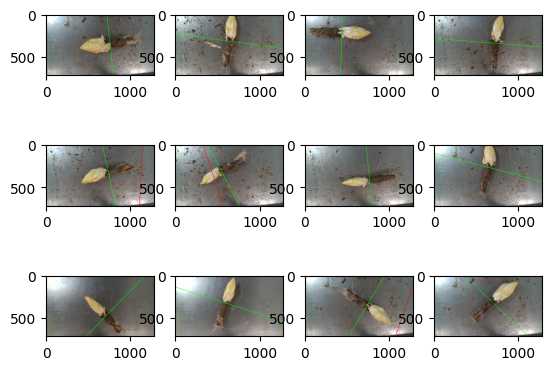

In [8]:
# Convert all images and labels
total_rmse = 0
for i, row in df_test.iterrows():

	# Define subplot
	plt.subplot(3, 4, i+1)

	# Get the image path name
	img_path = row["path_names"]

	# Read image
	image = cv2.imread(img_path) 
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	height, width, channels = image.shape

	# Get label
	key = img_path.split('\\')[-1].split('.')[0]
	label_file = open("../data/labels/" + key + ".txt", "r")
	labeldata = label_file.read().split(" ")

	# Get keypoints
	y = [(float(labeldata[4]), float(labeldata[5])), (float(labeldata[6]), float(labeldata[7]))]

	# Define augmentation pipeline
	transform = A.Compose([
		A.Resize(224, 224),
		A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
		ToTensorV2(),
	], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True))

	# Transform
	transformed = transform(image=image, keypoints=y)
	transformed_image = transformed['image']

	# Get ground truth line
	a1 = 0 if (y[1][0] - y[0][0]) == 0 else (y[1][1] - y[0][1]) / (y[1][0] - y[0][0])
	b1 = y[0][1] - a1*y[0][0]

	# Predict line 
	pred = model(transformed_image.unsqueeze(0).to(device).float()) # Unsqueeze to solve for missing batch dimension
	pred = pred.detach().cpu().numpy()[0]

	# Scale prediction to account for resizing
	pred[0] = pred[0] /224*width
	pred[1] = pred[1] /224*height
	pred[2] = pred[2] /224*width
	pred[3] = pred[3] /224*height

	# Get predicted line
	a2 = 0 if (pred[2] - pred[0]) == 0 else (pred[3] - pred[1]) / (pred[2] - pred[0])
	b2 = pred[1] - a2*pred[0]

	# Draw ground truth and predicted line
	draw_extended_line(image, a1, b1, color=(0, 255, 0), thickness=3)
	draw_extended_line(image, a2, b2, color=(255, 0, 0), thickness=3)

	# Visualize
	cv2.rectangle(image, (int(labeldata[0]), int(labeldata[1])), (int(labeldata[2]), int(labeldata[3])), (255, 0, 0), 1)
	plt.imshow(image)

	# Stop reading
	if i >= 3*4-1: break

# Show
plt.show()